In [4]:
import numpy
import pandas as pd
import random
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt

from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from scipy.spatial.distance import jaccard
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import mutual_info_score
import scipy.stats as st
from statsmodels.stats.multitest import multipletests



In [5]:
filename = "./mt_test.matrix.csv"
filename = "./HPRC/HG002.ccs.original.matrix.csv"
filename = "./HPRC/HG00438.ccs.original.matrix.csv"
df = pd.read_csv(filename, header = 0, index_col= 0)
# indexlist = df.sum(axis = 1)/df.shape[1]
# indexlist = indexlist[indexlist<0.5]
# df = df.loc[indexlist.index]
# df.shape

<Axes: xlabel='variant', ylabel='variant'>

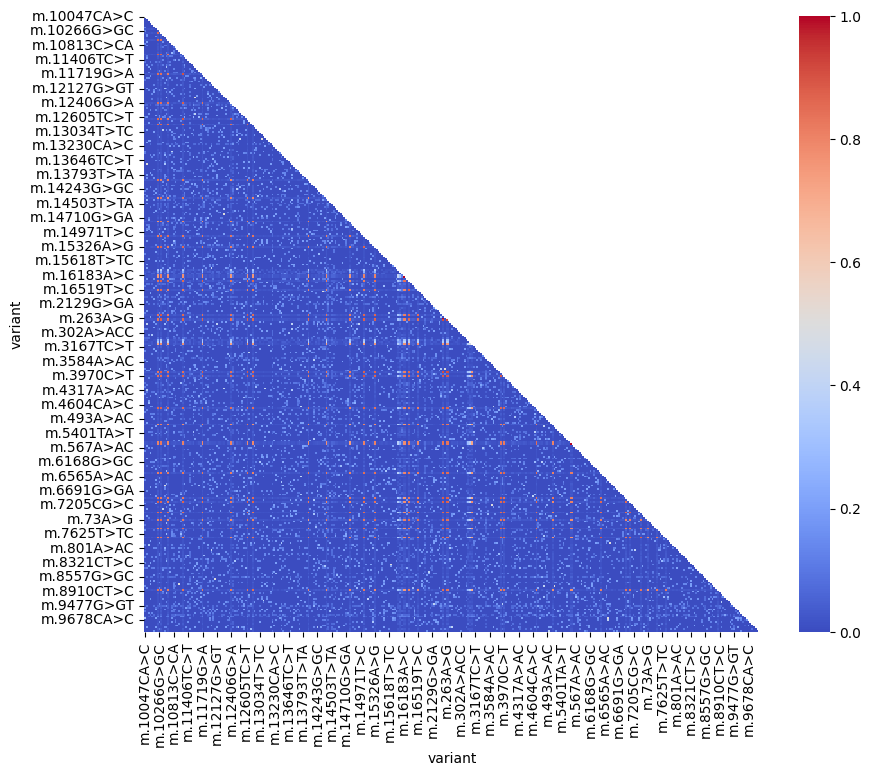

In [6]:
from scipy.spatial.distance import pdist, squareform
import numpy as np
# Compute the Jaccard similarity matrix
jaccard_distances = pdist(df, metric='jaccard')
jaccard_similarity = 1 - squareform(jaccard_distances)

# Convert the similarity matrix to a DataFrame for easier plotting
jaccard_similarity_df = pd.DataFrame(jaccard_similarity, index=df.index, columns=df.index)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(jaccard_similarity_df, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask
sns.heatmap(jaccard_similarity_df, mask=mask, annot=False, cmap='coolwarm', vmin=0, vmax=1, square=True)


<Axes: xlabel='variant', ylabel='variant'>

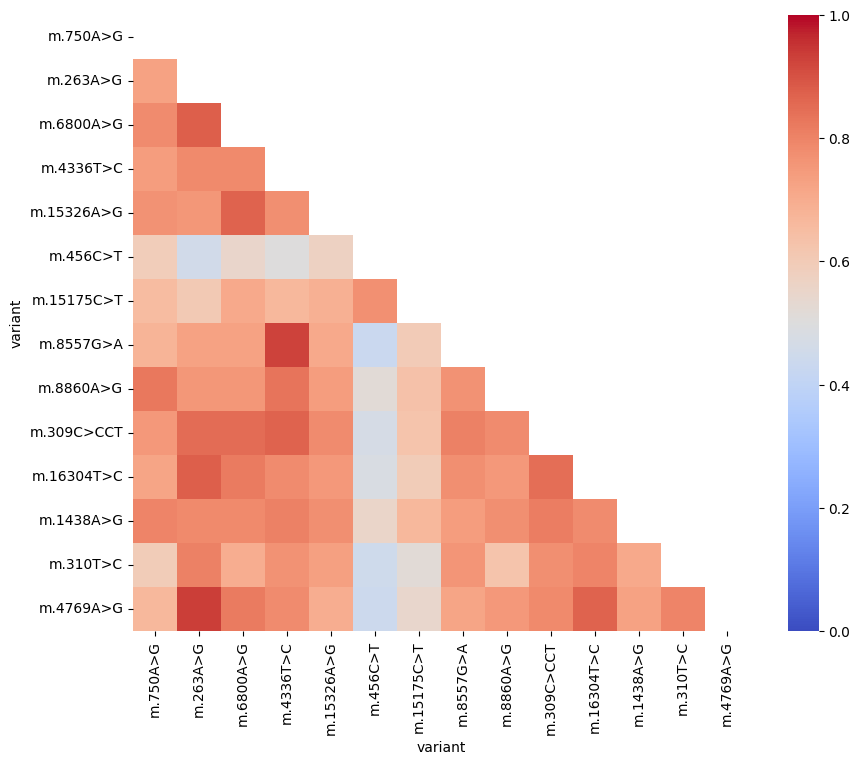

In [205]:

# filename = "./HPRC/HG002.ccs.matrix.csv"
# # filename = "./HPRC/HG00438.ccs.matrix.csv"
# df = pd.read_csv(filename, header = 0, index_col= 0)
jaccard_distances = pdist(df, metric='jaccard')
jaccard_similarity = 1 - squareform(jaccard_distances)

# Convert the similarity matrix to a DataFrame for easier plotting
jaccard_similarity_df = pd.DataFrame(jaccard_similarity, index=df.index, columns=df.index)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(jaccard_similarity_df, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask
sns.heatmap(jaccard_similarity_df, mask=mask, annot=False, cmap='coolwarm', vmin=0, vmax=1, square=True)



In [137]:
# sns.clustermap(coor)

<Axes: ylabel='Count'>

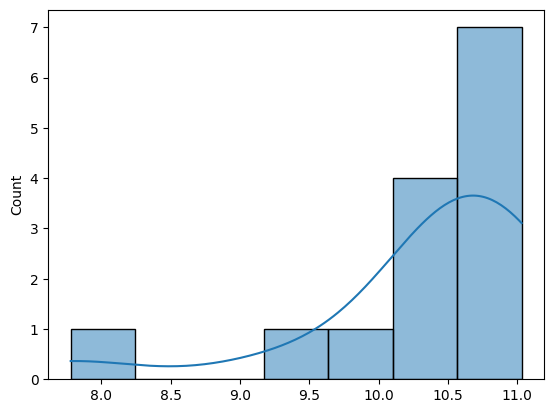

In [201]:
similarity = jaccard_similarity_df.sum()
sns.histplot(similarity, kde= True)

In [139]:
# for index, value in similarity.items():
#     if value > 10:
#         print(index)

In [7]:
def jaccard_similarity(vec1, vec2):
    v1 = numpy.asarray(vec1, dtype=bool)
    v2 = numpy.asarray(vec2, dtype=bool)

    intersection = numpy.sum(v1 & v2)
    union = numpy.sum(v1 | v2)
    return intersection / float(union)
def simple_matching_coefficient(v1, v2):
    matches = numpy.sum(v1 == v2)
    total = len(v1)
    return matches / float(total)

In [8]:
# permutation_round = 100

    # for index in indexlist:
def get_null_distribution(df, index, permutation_round):
    statistics = []
    indexlist = df.index.tolist()
    for p in range(permutation_round):
        # randomize vector
        for index in indexlist:
            vector = df.loc[index, :].values
            if sum(vector) / len(vector) > 0.5:
                continue
            shuffled = vector.copy()
            random.shuffle(shuffled)
            all_coefficient = []
            for other_index in indexlist:
                if index == other_index:
                    continue

                
                other_vector = df.loc[other_index, :].values
                # if sum(other_vector) / len(other_vector) < 0.5:
                #     continue
                # pearson coefficient
                # coor = numpy.absolute(numpy.corrcoef(shuffled, other_vector)[0,1])

                # jaccard distance
                # coor = numpy.absolute(matthews_corrcoef(shuffled, other_vector))
                coor  = numpy.absolute(1-jaccard(shuffled, other_vector))

                all_coefficient += [coor]
            statistics.append(numpy.sum(all_coefficient))
    return statistics

def calculate_observation_statistics(df, index):
    indexlist = df.index.tolist()
    vector = df.loc[index, :].values
    # calculate the aggregated coefficient
    all_coefficient = []
    for other_index in indexlist:
        if index == other_index:
            continue
        other_vector = df.loc[other_index, :].values
        # if sum(other_vector) / len(other_vector) < 0.5:
        #     continue
        # coor = numpy.absolute(numpy.corrcoef(vector, other_vector)[0,1])
        # coor  = mutual_info_score(vector, other_vector)
        coor  = numpy.absolute(1- jaccard(vector, other_vector))
        # coor = numpy.absolute(matthews_corrcoef(vector, other_vector))

        
        all_coefficient += [coor]
    return numpy.sum(all_coefficient)

def calculate_p_value(statistics, observation):
    mu, sigma = np.mean(statistics), np.std(statistics)
    z_score = (observation - mu)/sigma
    p_value = 1 - stats.norm.cdf(z_score)

    return p_value


In [9]:
def permutation_test(df, threshold = 0.01):
    indexlist = df.index.tolist()
    print(len(indexlist))
    permutation_round = 10
    excluded_index = []
    raw_p_values = []
    statistics = get_null_distribution(df,  index, permutation_round)
    for index in indexlist:
        if df.loc[index, :].sum()/df.shape[1] > 0.5:
            continue
        
        observation = calculate_observation_statistics(df, index)
        sns.histplot(statistics, kde=True)
        sns.histplot([observation])
        p_value = calculate_p_value(statistics, observation)
        # add multivariant correction
        raw_p_values.append(p_value)
    # multiple testing correction
    reject, corrected_p_values, _, _ = multipletests(raw_p_values, alpha=threshold, method= "fdr_bh")
    excluded_index = [indexlist[i] for i in range(len(indexlist)) 
                    if corrected_p_values[i] > threshold]
    # if p_value > threshold:
    #     # print(index, df.loc[index, :].sum()/df.shape[1])
    #     excluded_index.append(index)
        

    return excluded_index

    


343


KeyboardInterrupt: 

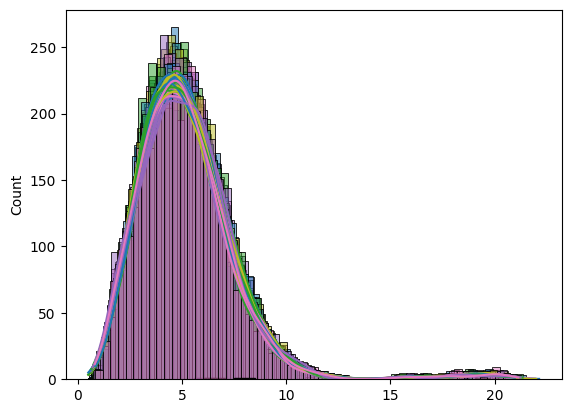

In [10]:
excluded_index = permutation_test(df)
excluded_index

In [ ]:
set(df.index) - set(excluded_index)

{'m.10134C>CA',
 'm.10223C>T',
 'm.10310G>A',
 'm.10414G>GT',
 'm.10421C>CA',
 'm.10472G>GC',
 'm.10609T>C',
 'm.10813C>CA',
 'm.10946A>AC',
 'm.10963A>G',
 'm.11031G>GA',
 'm.11426GC>G',
 'm.11520C>CA',
 'm.11634GC>G',
 'm.11711G>GC',
 'm.11719G>A',
 'm.11866A>AC',
 'm.12108A>AC',
 'm.12127G>GT',
 'm.12361A>AC',
 'm.12406G>A',
 'm.12431A>AC',
 'm.12556A>AC',
 'm.12576CA>C',
 'm.12618G>A',
 'm.12882C>T',
 'm.12967A>AC',
 'm.13052G>GC',
 'm.13230C>CA',
 'm.1339GC>G',
 'm.13582A>AC',
 'm.13651A>AC',
 'm.1374AC>A',
 'm.13928G>C',
 'm.14074C>CA',
 'm.14243G>GC',
 'm.14339A>AC',
 'm.14388A>AC',
 'm.1438A>G',
 'm.14424A>AC',
 'm.14710G>GA',
 'm.14766C>T',
 'm.14813A>AC',
 'm.1485G>GC',
 'm.14932C>CT',
 'm.15024G>A',
 'm.15214T>TG',
 'm.15326A>G',
 'm.1553A>AG',
 'm.16183A>C',
 'm.16189T>C',
 'm.16258A>AC',
 'm.16291C>T',
 'm.16374A>AC',
 'm.16519T>C',
 'm.2129G>GA',
 'm.2456T>TA',
 'm.247GA>G',
 'm.263A>G',
 'm.2706A>G',
 'm.2792A>AC',
 'm.2800T>TA',
 'm.285C>CA',
 'm.310T>C',
 'm.3413G>GC',

In [14]:
# # null distribution
# ax = sns.histplot(statistics, kde=True)
# ax.set_xlabel("Sum of absolute pearson correlation coefficient")

In [143]:
# len(statistics), permutation_round * df.shape[0]
# Convert to numpy array if not already

distribution = numpy.array(statistics)

# Fit normal distribution
mu, sigma = numpy.mean(distribution), numpy.std(distribution)


p_value_list = []
all_coefficients= []

for index in indexlist:
    vector = df.loc[index, :].values
    # calculate the aggregated coefficient
    all_coefficient = 0
    for other_index in indexlist:
        if index == other_index:
            continue
        other_vector = df.loc[other_index, :].values
        # coor = numpy.corrcoef(vector, other_vector)[0,1]
        # coor  = mutual_info_score(vector, other_vector)
        coor  = numpy.absolute( jaccard(vector, other_vector))

        
        all_coefficient += numpy.abs(coor)
    all_coefficients.append(all_coefficient)
    if all_coefficient > 16:
        print(index)
    # calculate p-values
    # z_score = (all_coefficient - mu)/sigma
    # p_value = 1 - stats.norm.cdf(z_score)
    # p_value_list.append(p_value)
    


m.11031G>GA
m.14154TC>T
m.14503T>TA
m.16183A>AC
m.309C>CCCT
m.310T>TC
m.3565A>AC
m.8604TC>T
m.9263AG>A
m.9570A>AC


In [137]:
# y, x = numpy.histogram(statistics, bins = 10)
# y1, x1 = numpy.histogram(all_coefficients, bins = 10)
# plt.plot(x[1:], numpy.log10(y+1), label = "Null")
# plt.plot(x1[1:], numpy.log10(y1+1), label = "data")

<Axes: ylabel='Density'>

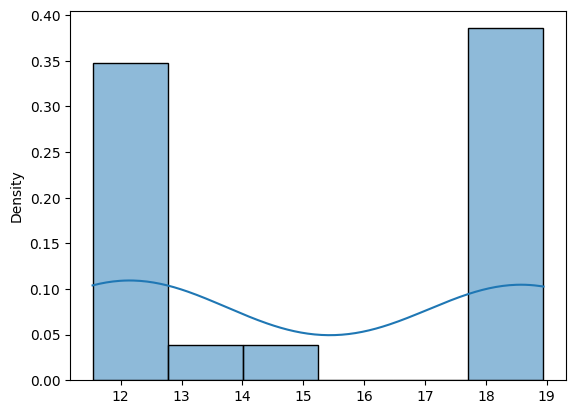

In [141]:
# sns.histplot(statistics, kde=True,  stat="density")
sns.histplot(all_coefficients, kde = True, stat = "density")

In [91]:
df

,m54329U_201103_231616/109970129/ccs,m54329U_201103_231616/116393834/ccs,m54329U_201103_231616/135660096/ccs,m54329U_201103_231616/143852432/ccs,m54329U_201103_231616/166397033/ccs,m54329U_201103_231616/37684585/ccs,m54329U_201103_231616/39455569/ccs,m54329U_201103_231616/46597678/ccs,m54329U_201103_231616/51970410/ccs,m54329U_201103_231616/62326850/ccs,...,m64076_201013_225902/60098837/ccs,m64076_201013_225902/67437588/ccs,m64076_201013_225902/71762487/ccs,m64076_201016_191536/133694885/ccs,m64076_201016_191536/137233620/ccs,m64076_201016_191536/141495087/ccs,m64076_201016_191536/38472383/ccs,m64076_201016_191536/50923682/ccs,m64076_201016_191536/6358056/ccs,m64076_201016_191536/83298391/ccs
variant,,,,,,,,,,,,,,,,,,,,,
m.11031G>GA,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
m.14154TC>T,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
m.1438A>G,1,0,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,0,0,1,0
m.14503T>TA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
m.15175C>T,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
m.15326A>G,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
m.16183A>AC,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
m.16304T>C,1,1,1,0,1,1,1,1,1,0,...,1,1,1,0,1,1,1,1,1,1
m.263A>G,1,0,1,0,1,1,0,1,1,1,...,1,1,1,1,0,1,1,0,1,1


In [94]:
variant_list = df.index.tolist()
for i, p in enumerate(p_value_list):
    if p >0.01:
        print(variant_list[i])


In [95]:
p_value_list

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]